Using individual-level data on their pre-existing health status and habits, I aim to predict if a person between age 20 to 30 is likely to test positive or negative for COVID. I obtain the data from https://www.kaggle.com/tanmoyx/covid19-patient-precondition-dataset The data contains information on patients' existing health conditions and their COVID test result.

In [1]:
import sys
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as st
%matplotlib inline
import types
from botocore.client import Config
import ibm_boto3

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# models
import sklearn
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
#from tensorflow.keras.layers import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pickle



In [2]:
#Getting the data
!wget https://raw.githubusercontent.com/mohityprakash/advanced-data-science-IBM-capstone/main/covid.csv

--2021-05-26 15:12:41--  https://raw.githubusercontent.com/mohityprakash/advanced-data-science-IBM-capstone/main/covid.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46684628 (45M) [text/plain]
Saving to: ‘covid.csv’

covid.csv           100%[===================>]  44.52M   125MB/s    in 0.4s    

2021-05-26 15:12:43 (125 MB/s) - ‘covid.csv’ saved [46684628/46684628]



In [3]:
df = pd.read_csv("covid.csv")

In [4]:
#First Look At Data
df.head()

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,9999-99-99,97,2,27,97,...,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,9999-99-99,97,2,24,97,...,2,2,2,2,2,2,2,99,1,97
2,167386,1,2,06-04-2020,01-04-2020,9999-99-99,2,2,54,2,...,2,2,2,2,1,2,2,99,1,2
3,0b5948,2,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,97,...,2,2,2,2,2,2,2,99,1,2
4,0d01b5,1,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,...,2,1,2,1,2,2,2,99,1,2


In [5]:
#keep ages between 20 to 30
df = df[df['age'] <= 30]

In [6]:
df = df[df['age'] >= 20]

Data Exploration

In [7]:
# View column names 
df.columns

Index(['id', 'sex', 'patient_type', 'entry_date', 'date_symptoms', 'date_died',
       'intubed', 'pneumonia', 'age', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco', 'contact_other_covid',
       'covid_res', 'icu'],
      dtype='object')

In [8]:
# statistical properties of dataset
df.describe()

,sex,patient_type,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
count,107819.000000,107819.000000,107819.000000,107819.000000,107819.000000,107819.000000,107819.000000,107819.000000,107819.000000,107819.000000,107819.000000,107819.000000,107819.000000,107819.000000,107819.000000,107819.000000,107819.000000,107819.000000,107819.000000
mean,1.480917,1.072288,90.137953,1.950528,26.138417,47.977008,2.187805,2.189447,2.159007,2.203332,2.172372,2.258591,2.192953,2.087035,2.182658,2.118996,27.393669,1.801899,90.136859
std,0.499638,0.258965,24.600521,0.698470,2.888439,47.500154,4.402545,4.282958,4.337812,4.506756,4.355635,5.151205,4.372207,4.377831,4.284046,4.557175,43.160194,0.626122,24.604464
min,1.000000,1.000000,1.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,97.000000,2.000000,24.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,97.000000
50%,1.000000,1.000000,97.000000,2.000000,27.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,97.000000
75%,2.000000,1.000000,97.000000,2.000000,29.000000,97.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,2.000000,97.000000
max,2.000000,2.000000,99.000000,99.000000,30.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,99.000000,3.000000,99.000000


In [9]:
# summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107819 entries, 0 to 566595
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id                   107819 non-null  object
 1   sex                  107819 non-null  int64 
 2   patient_type         107819 non-null  int64 
 3   entry_date           107819 non-null  object
 4   date_symptoms        107819 non-null  object
 5   date_died            107819 non-null  object
 6   intubed              107819 non-null  int64 
 7   pneumonia            107819 non-null  int64 
 8   age                  107819 non-null  int64 
 9   pregnancy            107819 non-null  int64 
 10  diabetes             107819 non-null  int64 
 11  copd                 107819 non-null  int64 
 12  asthma               107819 non-null  int64 
 13  inmsupr              107819 non-null  int64 
 14  hypertension         107819 non-null  int64 
 15  other_disease        107819 non-nu

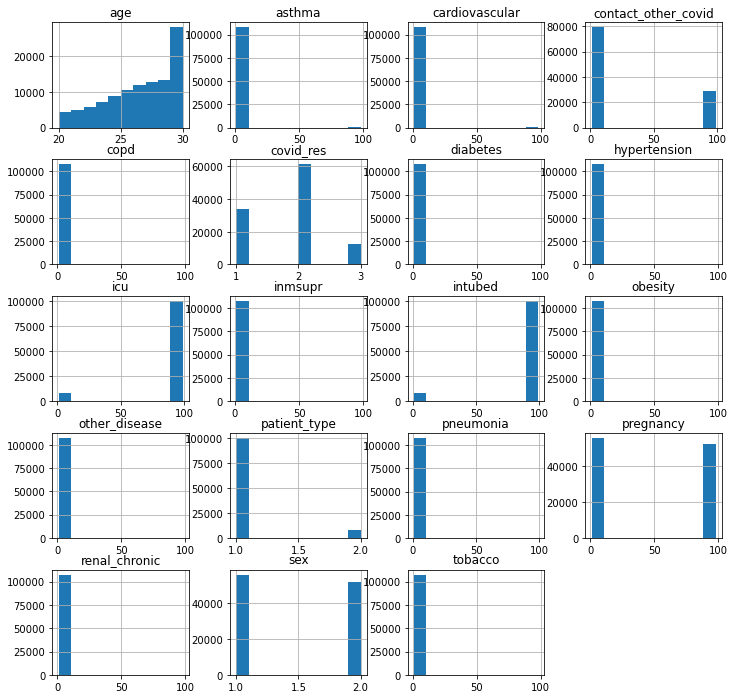

In [10]:
#Creating histograms
df.hist(figsize = (12, 12))
plt.show()

In [11]:
#Finding correlation
correlation = df.corr()
correlation["covid_res"].sort_values(ascending=False)

covid_res              1.000000
intubed                0.045752
icu                    0.045740
pneumonia              0.017992
hypertension           0.009943
renal_chronic          0.009552
obesity                0.008811
tobacco                0.008570
copd                   0.008506
diabetes               0.008231
cardiovascular         0.008048
other_disease          0.007377
asthma                 0.007336
inmsupr                0.006876
age                   -0.021424
sex                   -0.025707
pregnancy             -0.025718
patient_type          -0.045819
contact_other_covid   -0.049199
Name: covid_res, dtype: float64

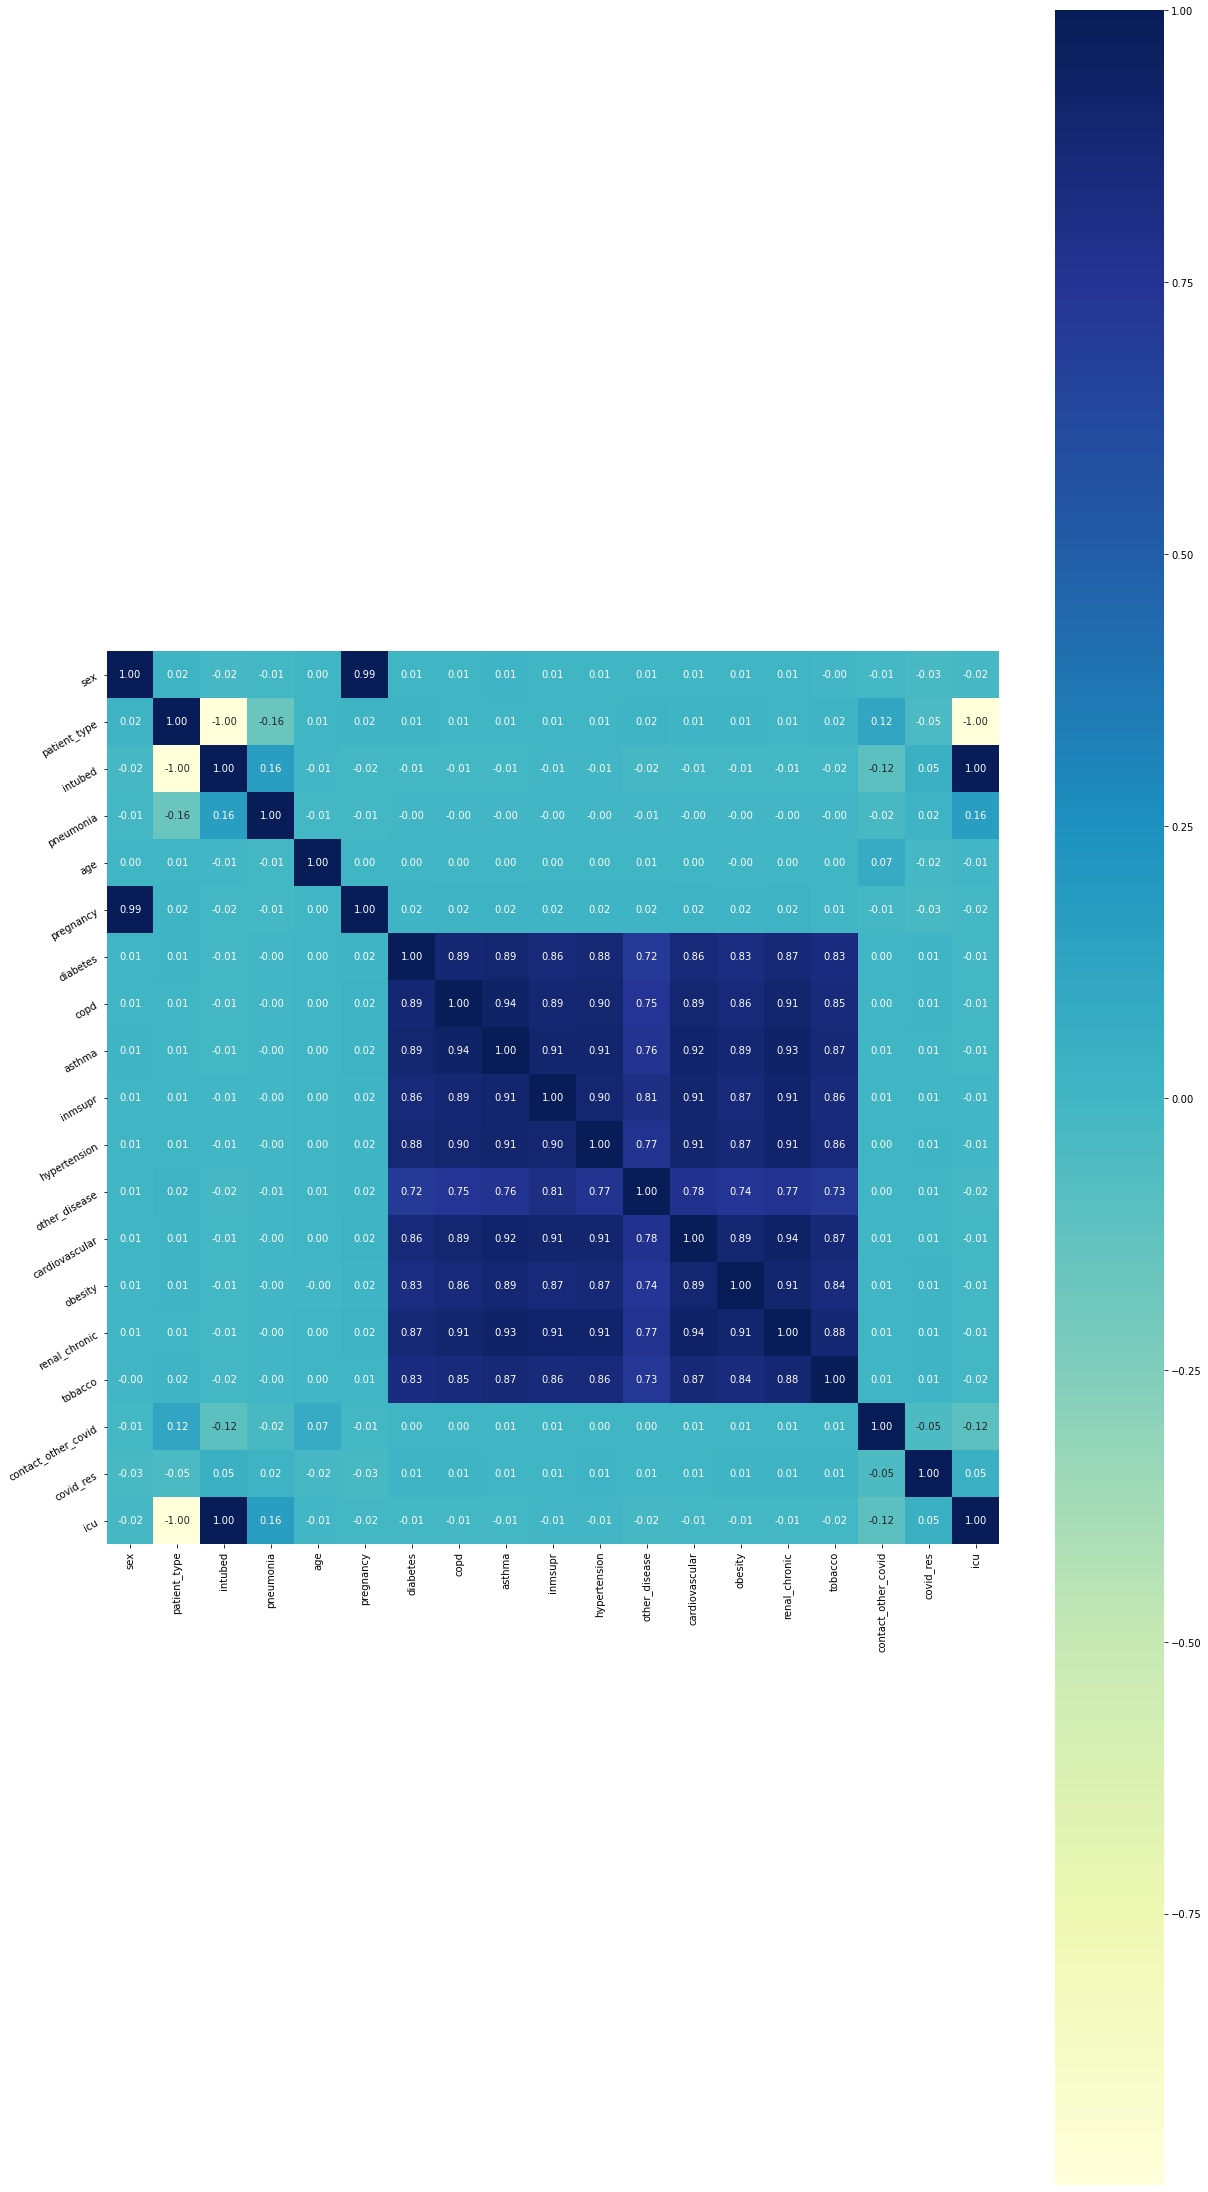

In [12]:
#Correlation matrix
plt.figure(figsize=(20,40))
a = sns.heatmap(correlation, cmap='YlGnBu', square=True, annot=True, fmt='.2f', linecolor='green')
a.set_xticklabels(a.get_xticklabels(), rotation=90)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()

Data Cleaning & Feature Engineering 

In [10]:
#drop columns which are not required
df = df.drop(columns= ["id","date_symptoms", "date_died", "intubed", "icu","entry_date","patient_type"])

In [11]:
#drop columns where COVID results have not been recorded
df = df[df['covid_res'] != 3]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95249 entries, 0 to 499689
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   sex                  95249 non-null  int64
 1   pneumonia            95249 non-null  int64
 2   age                  95249 non-null  int64
 3   pregnancy            95249 non-null  int64
 4   diabetes             95249 non-null  int64
 5   copd                 95249 non-null  int64
 6   asthma               95249 non-null  int64
 7   inmsupr              95249 non-null  int64
 8   hypertension         95249 non-null  int64
 9   other_disease        95249 non-null  int64
 10  cardiovascular       95249 non-null  int64
 11  obesity              95249 non-null  int64
 12  renal_chronic        95249 non-null  int64
 13  tobacco              95249 non-null  int64
 14  contact_other_covid  95249 non-null  int64
 15  covid_res            95249 non-null  int64
dtypes: int64(16)
memory u

In [13]:
df = df.sample(frac=.05)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4762 entries, 296633 to 197931
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   sex                  4762 non-null   int64
 1   pneumonia            4762 non-null   int64
 2   age                  4762 non-null   int64
 3   pregnancy            4762 non-null   int64
 4   diabetes             4762 non-null   int64
 5   copd                 4762 non-null   int64
 6   asthma               4762 non-null   int64
 7   inmsupr              4762 non-null   int64
 8   hypertension         4762 non-null   int64
 9   other_disease        4762 non-null   int64
 10  cardiovascular       4762 non-null   int64
 11  obesity              4762 non-null   int64
 12  renal_chronic        4762 non-null   int64
 13  tobacco              4762 non-null   int64
 14  contact_other_covid  4762 non-null   int64
 15  covid_res            4762 non-null   int64
dtypes: int64(16)
memo

In [15]:
#Check for null values
df.isnull().sum()

sex                    0
pneumonia              0
age                    0
pregnancy              0
diabetes               0
copd                   0
asthma                 0
inmsupr                0
hypertension           0
other_disease          0
cardiovascular         0
obesity                0
renal_chronic          0
tobacco                0
contact_other_covid    0
covid_res              0
dtype: int64

In [16]:
#assert that there are no missing values in the dataframe
assert pd.notnull(df).all().all()

In [17]:
#Since the data is categorical, we need to dummify it
df = pd.get_dummies(df,columns=["sex","pneumonia","pregnancy","diabetes","copd","asthma","inmsupr","hypertension","other_disease","cardiovascular","obesity","renal_chronic","tobacco"])

In [18]:
#Dropping columns where some feature was not specified
df = df.drop(columns= ["pneumonia_99", "diabetes_98", "copd_98", "asthma_98","inmsupr_98","hypertension_98","other_disease_98","cardiovascular_98","obesity_98","renal_chronic_98","tobacco_98"])

In [19]:
correlation = df.corr()
correlation["covid_res"].sort_values(ascending=False)

covid_res              1.000000
pneumonia_2            0.081494
obesity_2              0.049449
sex_1                  0.036928
pregnancy_2            0.036880
hypertension_2         0.033265
renal_chronic_2        0.031244
tobacco_1              0.030179
asthma_1               0.018210
copd_2                 0.015484
other_disease_2        0.014932
inmsupr_1              0.008509
diabetes_1             0.004828
pregnancy_1            0.001090
cardiovascular_2       0.000026
cardiovascular_1      -0.002312
diabetes_2            -0.002697
pregnancy_98          -0.002698
inmsupr_2             -0.008512
other_disease_1       -0.012914
age                   -0.017340
copd_1                -0.017555
asthma_2              -0.018162
tobacco_2             -0.030667
renal_chronic_1       -0.034188
hypertension_1        -0.036747
pregnancy_97          -0.036928
sex_2                 -0.036928
obesity_1             -0.050375
contact_other_covid   -0.063298
pneumonia_1           -0.082316
Name: co

In [20]:
#Dropping columns which have low correlation with covid_res
df = df.drop(columns= ["inmsupr_1","inmsupr_2","renal_chronic_2","renal_chronic_1","asthma_1","asthma_2","copd_2","copd_1","other_disease_1","other_disease_2","pregnancy_98"])

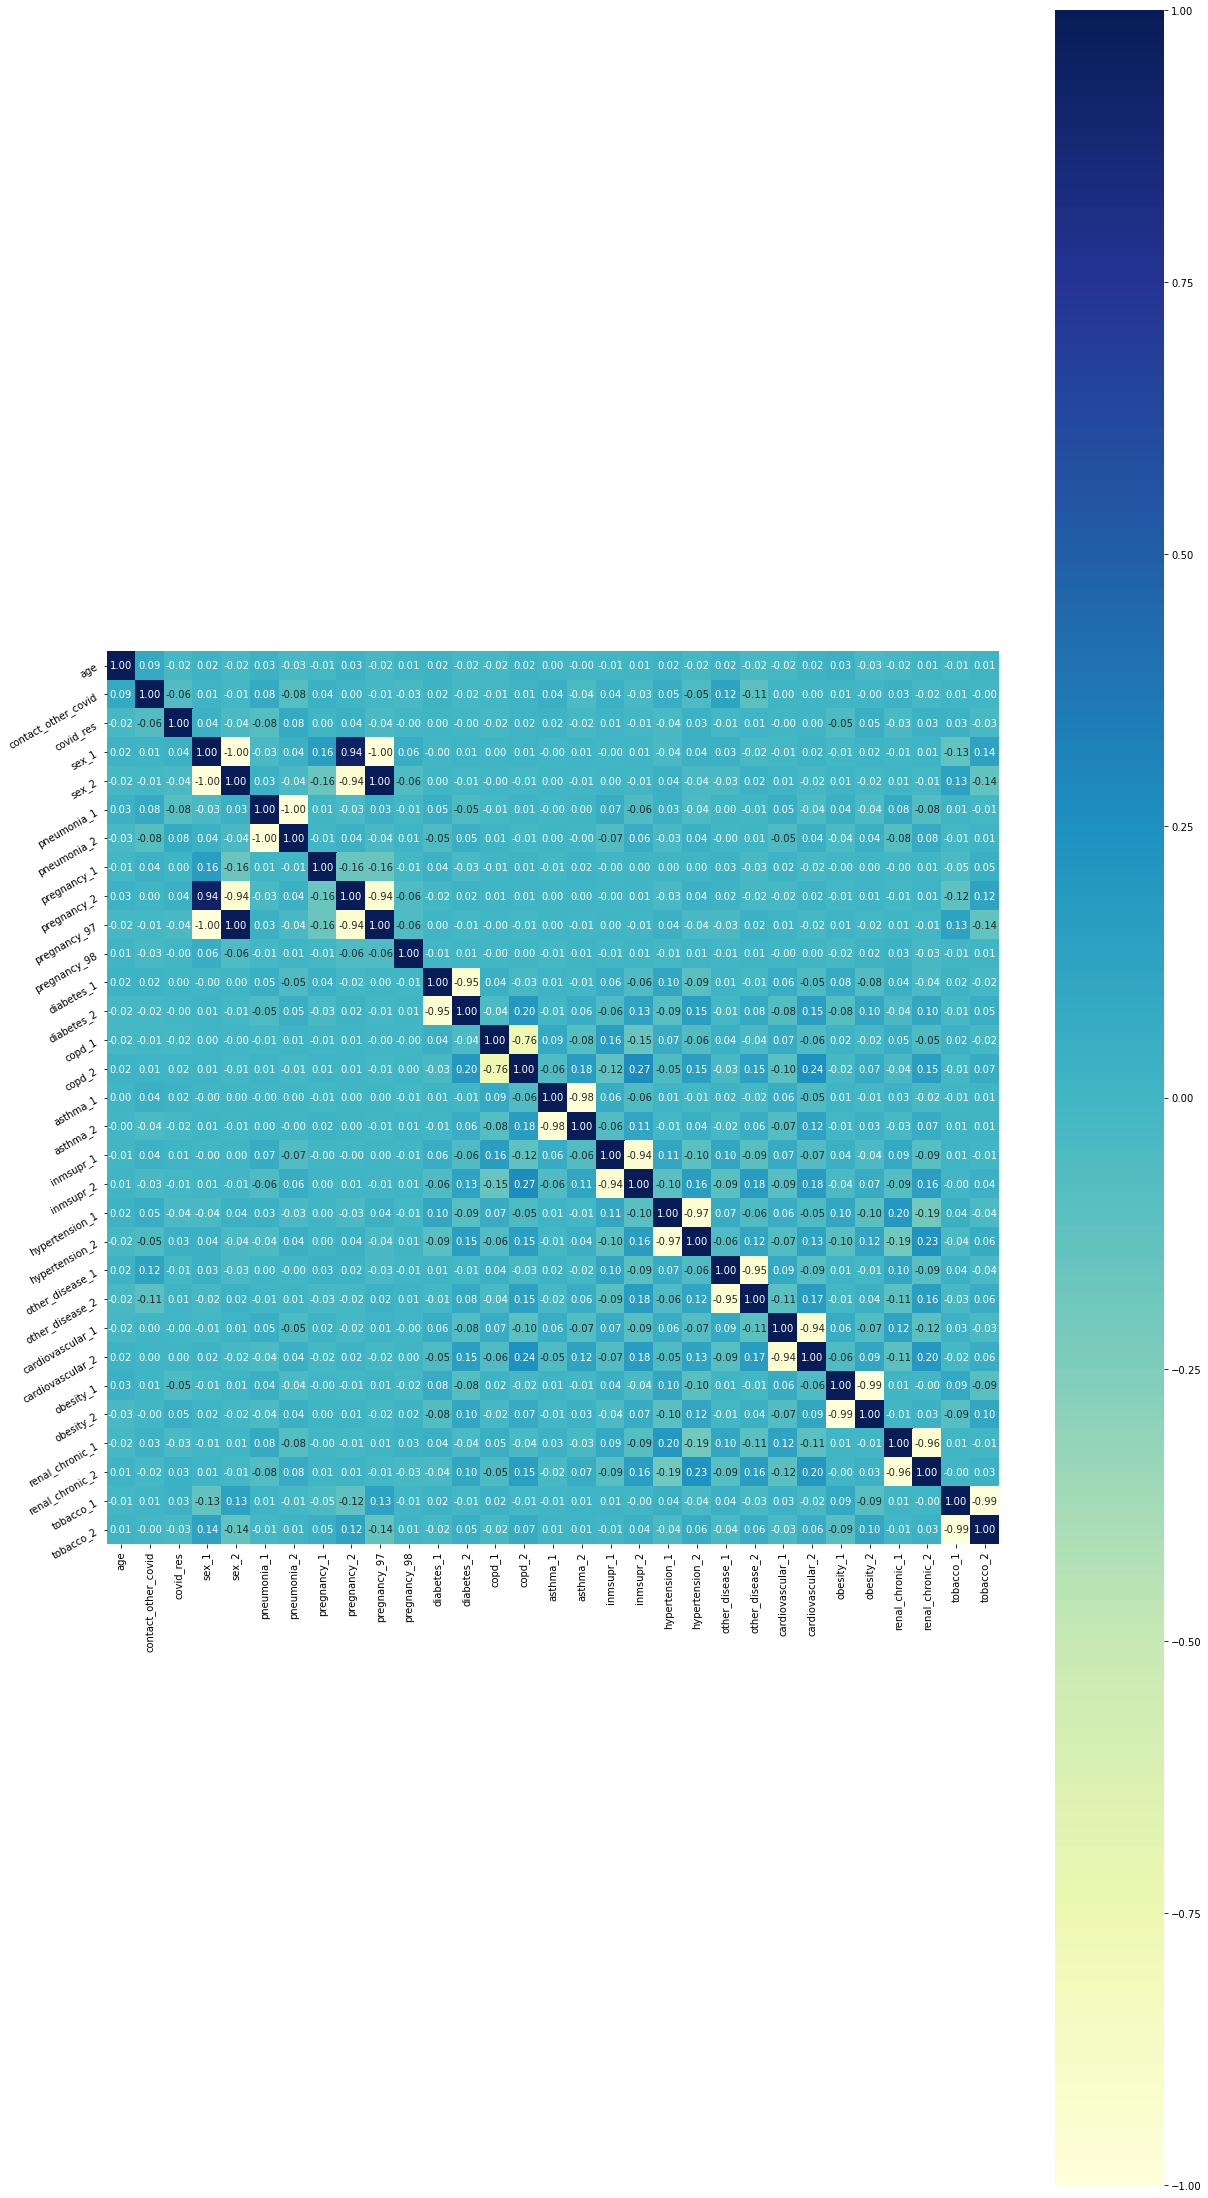

In [21]:
plt.figure(figsize=(20,40))
a = sns.heatmap(correlation, cmap='YlGnBu', square=True, annot=True, fmt='.2f', linecolor='green')
a.set_xticklabels(a.get_xticklabels(), rotation=90)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()

Machine Learning Models

In [22]:
target_name = 'covid_res'
data_target = df[target_name]
data = df.drop([target_name], axis=1)

In [23]:
# Split data on 20% in the test dataset, the remaining 80% - in the training dataset

train, test, target, target_test = train_test_split(data, data_target, test_size=0.2, random_state=0)

In [24]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(train, target)
acc_log = round(logreg.score(train, target) * 100, 2)
acc_log

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


65.24

In [25]:
acc_test_log = round(logreg.score(test, target_test) * 100, 2)
acc_test_log

63.48

In [26]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(train, target)
acc_gaussian = round(gaussian.score(train, target) * 100, 2)
acc_gaussian

62.96

In [27]:
acc_test_gaussian = round(gaussian.score(test, target_test) * 100, 2)
acc_test_gaussian

62.96

In [28]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes'],
    
    'Score_train': [acc_log, acc_gaussian],
    
    'Score_test': [acc_test_log, acc_test_gaussian]
                    })

In [29]:
models.sort_values(by=['Score_train', 'Score_test'], ascending=False)

,Model,Score_train,Score_test
0,Logistic Regression,65.24,63.48
1,Naive Bayes,62.96,62.96


In [ ]:
Deep Learning Model

In [37]:
# create X and Y datasets for training
from sklearn import model_selection
X = np.array(df.drop(['covid_res'], 1))
y = np.array(df['covid_res'])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

In [38]:
# convert the data to categorical labels

from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(y_train, num_classes=None)
Y_test = to_categorical(y_test, num_classes=None)
print (Y_train.shape)
print (Y_train[:10])

(3809, 3)
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# define a function to build the keras model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=19, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    # compile model
    adam = Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

model = create_model()

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                320       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 27        
Total params: 483
Trainable params: 483
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
# fit the model to the training data
history=model.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=10, batch_size=10, verbose = 1)


Train on 3809 samples, validate on 953 samples
Epoch 1/10
3809/3809 [==============================] - 340s 89ms/sample - loss: 0.6441 - accuracy: 0.6469 - val_loss: 0.6525 - val_accuracy: 0.6401
Epoch 2/10
3809/3809 [==============================] - 347s 91ms/sample - loss: 0.6452 - accuracy: 0.6482 - val_loss: 0.6482 - val_accuracy: 0.6464
Epoch 3/10
3809/3809 [==============================] - 347s 91ms/sample - loss: 0.6448 - accuracy: 0.6469 - val_loss: 0.6475 - val_accuracy: 0.6432
Epoch 4/10
3809/3809 [==============================] - 338s 89ms/sample - loss: 0.6442 - accuracy: 0.6485 - val_loss: 0.6505 - val_accuracy: 0.6464
Epoch 5/10
3809/3809 [==============================] - 336s 88ms/sample - loss: 0.6431 - accuracy: 0.6493 - val_loss: 0.6485 - val_accuracy: 0.6474
Epoch 6/10
3809/3809 [==============================] - 339s 89ms/sample - loss: 0.6434 - accuracy: 0.6556 - val_loss: 0.6473 - val_accuracy: 0.6506
Epoch 7/10
3809/3809 [==============================] - 338

In [49]:
score = model.evaluate(X_test, Y_test,
                       batch_size=10, verbose=1)
 
print('Test loss:', score[0])
print('Test accuracy:', score[1])

953/953 [==============================] - 41s 43ms/sample - loss: 0.6472 - accuracy: 0.6516
Test loss: 0.647198968581613
Test accuracy: 0.65162647


In [51]:
print(history.keys())

AttributeError: 'History' object has no attribute 'keys'

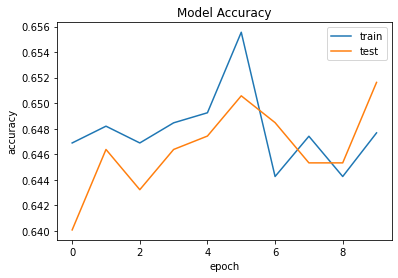

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

# Model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

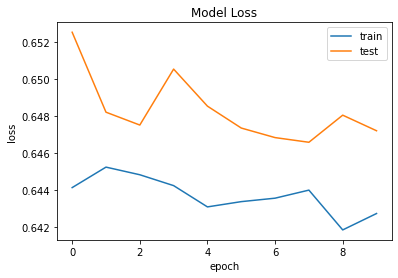

In [53]:
# Model Losss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [54]:
# convert into binary classification problem - heart disease or no heart disease
Y_train_binary = y_train.copy()
Y_test_binary = y_test.copy()

Y_train_binary[Y_train_binary > 0] = 1
Y_test_binary[Y_test_binary > 0] = 1

print(Y_train_binary[:20])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [57]:
# define a new keras model for binary classification
def create_binary_model():
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=19, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    adam = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

binary_model = create_binary_model()

print(binary_model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 16)                320       
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________
None


In [58]:
history=binary_model.fit(X_train, Y_train_binary, validation_data=(X_test, Y_test_binary), epochs=10, batch_size=10, verbose = 1)

Train on 3809 samples, validate on 953 samples
Epoch 1/10
3809/3809 [==============================] - 287s 75ms/sample - loss: 0.0524 - accuracy: 1.0000 - val_loss: 6.8050e-04 - val_accuracy: 1.0000
Epoch 2/10
3809/3809 [==============================] - 300s 79ms/sample - loss: 3.3460e-04 - accuracy: 1.0000 - val_loss: 1.7079e-04 - val_accuracy: 1.0000
Epoch 3/10
3809/3809 [==============================] - 300s 79ms/sample - loss: 1.1127e-04 - accuracy: 1.0000 - val_loss: 7.4807e-05 - val_accuracy: 1.0000
Epoch 4/10
3809/3809 [==============================] - 357s 94ms/sample - loss: 5.4581e-05 - accuracy: 1.0000 - val_loss: 4.0989e-05 - val_accuracy: 1.0000
Epoch 5/10
3809/3809 [==============================] - 328s 86ms/sample - loss: 3.1723e-05 - accuracy: 1.0000 - val_loss: 2.5274e-05 - val_accuracy: 1.0000
Epoch 6/10
3809/3809 [==============================] - 288s 75ms/sample - loss: 2.0262e-05 - accuracy: 1.0000 - val_loss: 1.6704e-05 - val_accuracy: 1.0000
Epoch 7/10
3809

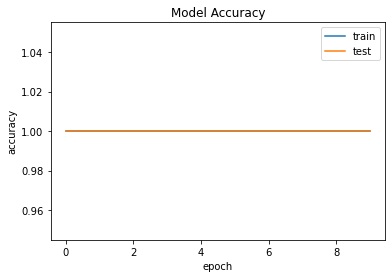

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

# Model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

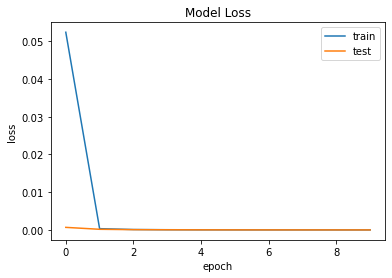

In [60]:
# Model Losss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [61]:
# generate classification report using predictions for categorical model
from sklearn.metrics import classification_report, accuracy_score

categorical_pred = np.argmax(model.predict(X_test), axis=1)

print('Results for Categorical Model')
print(accuracy_score(y_test, categorical_pred))
print(classification_report(y_test, categorical_pred))

Results for Categorical Model
0.6516264428121721
              precision    recall  f1-score   support

           1       0.65      0.06      0.11       341
           2       0.65      0.98      0.78       612

    accuracy                           0.65       953
   macro avg       0.65      0.52      0.45       953
weighted avg       0.65      0.65      0.54       953



In [62]:
# generate classification report using predictions for categorical model
from sklearn.metrics import classification_report, accuracy_score
# generate classification report using predictions for binary model 
binary_pred = np.round(binary_model.predict(X_test)).astype(int)

print('Results for Binary Model')
print(accuracy_score(Y_test_binary, binary_pred))
print(classification_report(Y_test_binary, binary_pred))

Results for Binary Model
1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       953

    accuracy                           1.00       953
   macro avg       1.00      1.00      1.00       953
weighted avg       1.00      1.00      1.00       953

